In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from pathlib import Path
import numpy as np
from scipy.ndimage import rotate

In [3]:
import warnings
warnings.filterwarnings('ignore') 

In [4]:
DATA_FOLDER = Path("../data")
saint_denis_path = DATA_FOLDER / "saint_denis_reference_data.gpkg"


In [5]:
batiments = gpd.read_file(saint_denis_path, layer="bdtopo_batiment").to_crs(2154)

ecoles = gpd.read_file(saint_denis_path, layer="bdtopo_education").to_crs(2154)

In [6]:
from potentiel_solaire.features.roof_attributes import  recuperation_mnh, recuperation_mns
from potentiel_solaire.features.roof_horizon import getAngles, get_horizon_roof


# On choisit une école avec plusieurs batiments

In [7]:
ecole_cible = ecoles.iloc[[5]]  # On prend la 6ème école par exemple
ecole_cible = ecole_cible.to_crs(2154)
zone_ecole = ecole_cible.copy()
zone = ecole_cible.geometry.iloc[0]
# On va examiner dans un rayon de 100m
ecole_cible['geometry'] = ecole_cible.geometry.buffer(60)
batiments_ecole = batiments[batiments.within(zone)]
batiments_ecole

,cleabs_left__bat,nature__bat,usage_1,usage_2,construction_legere,etat_de_l_objet__bat,date_creation_left__bat,date_modification_left__bat,date_d_apparition_left__bat,date_de_confirmation_left__bat,...,chef_lieu_de_departement__zone,chef_lieu_de_region__zone,capitale_d_etat__zone,date_du_recensement__zone,organisme_recenseur__zone,codes_siren_des_epci__zone,lien_vers_chef_lieu__zone,liens_vers_autorite_administrative__zone,code_siren__zone,geometry
7,BATIMENT0000000243399191,Indifférenciée,Commercial et services,None,False,En service,2010-09-06 11:50:34.561,2019-01-09 13:08:55.077,None,NaT,...,False,False,False,2021-01-01,INSEE,200054781/200057867,PAIHABIT0000000002597636,SURFACTI0000000002556769,219300662,"MULTIPOLYGON Z (((651971 6869269.7 40.4, 65197..."
14,BATIMENT0000000243399973,Indifférenciée,Commercial et services,None,False,En service,2010-09-06 11:51:31.363,2019-01-09 13:08:55.077,None,NaT,...,False,False,False,2021-01-01,INSEE,200054781/200057867,PAIHABIT0000000002597636,SURFACTI0000000002556769,219300662,"MULTIPOLYGON Z (((652014.6 6869306 45.9, 65201..."
15,BATIMENT0000000243399188,Indifférenciée,Commercial et services,None,False,En service,2010-09-06 11:50:34.561,2019-01-09 13:08:55.077,None,NaT,...,False,False,False,2021-01-01,INSEE,200054781/200057867,PAIHABIT0000000002597636,SURFACTI0000000002556769,219300662,"MULTIPOLYGON Z (((651949.5 6869258.8 41.6, 651..."
16,BATIMENT0000000243399190,Indifférenciée,Commercial et services,None,False,En service,2010-09-06 11:50:34.561,2019-01-09 13:08:55.077,None,NaT,...,False,False,False,2021-01-01,INSEE,200054781/200057867,PAIHABIT0000000002597636,SURFACTI0000000002556769,219300662,"MULTIPOLYGON Z (((651960.2 6869257.6 40.6, 651..."
17,BATIMENT0000000243399187,Indifférenciée,Commercial et services,None,False,En service,2010-09-06 11:50:34.561,2019-01-09 13:08:55.077,None,NaT,...,False,False,False,2021-01-01,INSEE,200054781/200057867,PAIHABIT0000000002597636,SURFACTI0000000002556769,219300662,"MULTIPOLYGON Z (((651949.5 6869258.8 41.5, 651..."
18,BATIMENT0000000243399972,Indifférenciée,Commercial et services,None,True,En service,2010-09-06 11:51:31.363,2019-01-09 13:08:55.077,None,NaT,...,False,False,False,2021-01-01,INSEE,200054781/200057867,PAIHABIT0000000002597636,SURFACTI0000000002556769,219300662,"MULTIPOLYGON Z (((652000.5 6869260.2 40.7, 652..."
19,BATIMENT0000000243399189,Indifférenciée,Commercial et services,None,False,En service,2010-09-06 11:50:34.561,2019-01-09 13:08:55.077,None,NaT,...,False,False,False,2021-01-01,INSEE,200054781/200057867,PAIHABIT0000000002597636,SURFACTI0000000002556769,219300662,"MULTIPOLYGON Z (((651947.8 6869277.4 40.3, 651..."
21,BATIMENT0000000243399192,Indifférenciée,Commercial et services,None,True,En service,2010-09-06 11:50:34.561,2022-07-30 23:16:38.938,None,NaT,...,False,False,False,2021-01-01,INSEE,200054781/200057867,PAIHABIT0000000002597636,SURFACTI0000000002556769,219300662,"MULTIPOLYGON Z (((651976 6869272.5 -1000, 6519..."
22,BATIMENT0000000243399193,Indifférenciée,Commercial et services,None,True,En service,2010-09-06 11:50:34.561,2022-07-30 23:16:38.938,None,NaT,...,False,False,False,2021-01-01,INSEE,200054781/200057867,PAIHABIT0000000002597636,SURFACTI0000000002556769,219300662,"MULTIPOLYGON Z (((651970.9 6869274.9 -1000, 65..."
24,BATIMENT0000000243400186,Indifférenciée,Commercial et services,None,False,En service,2010-09-06 11:51:31.363,2019-01-09 13:08:55.077,None,NaT,...,False,False,False,2021-01-01,INSEE,200054781/200057867,PAIHABIT0000000002597636,SURFACTI0000000002556769,219300662,"MULTIPOLYGON Z (((652040.1 6869298.1 42.5, 652..."


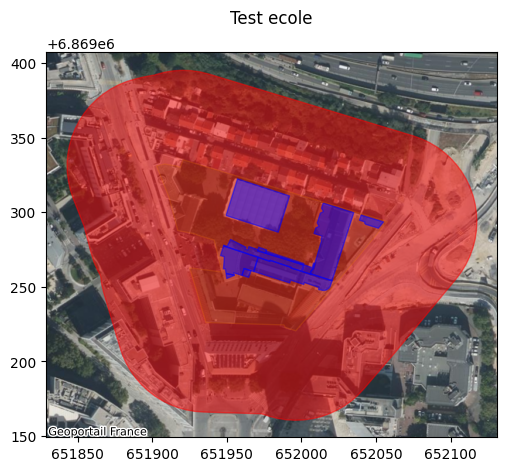

In [8]:
fig, ax = plt.subplots(figsize=(15,5))

zone_ecole.plot(ax=ax, alpha=0.2, color ="green", edgecolor='yellow')
ecole_cible.plot(ax=ax, alpha=0.5, color ="red", edgecolor='red')
batiments_ecole.plot(ax=ax, alpha=0.5, color ="blue", edgecolor='blue')
ax.set_title("Test ecole\n") 
#@TODO remettre fond de carte
cx.add_basemap(ax, crs=ecole_cible.crs, source=cx.providers.GeoportailFrance.orthos )
fig.show()

In [9]:
H = recuperation_mnh(ecole_cible, cache=True)[0]
Hbis = rotate(H, angle=-45,reshape=True)
h = recuperation_mns(ecole_cible, cache=True)[0] 
hbis = rotate(h, angle=-45,reshape=True)

# Etude axe Nord/Sud

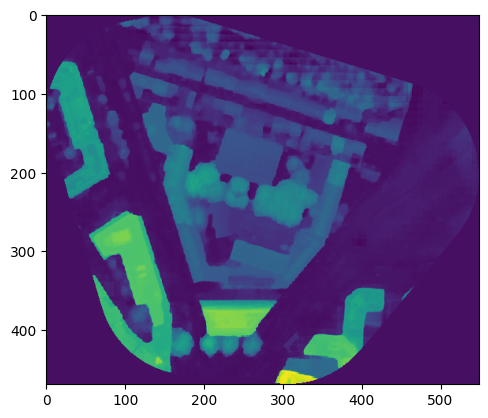

In [10]:
plt.imshow(H)

### Profil des hauteurs selon un Axe N/S

Values 1 10


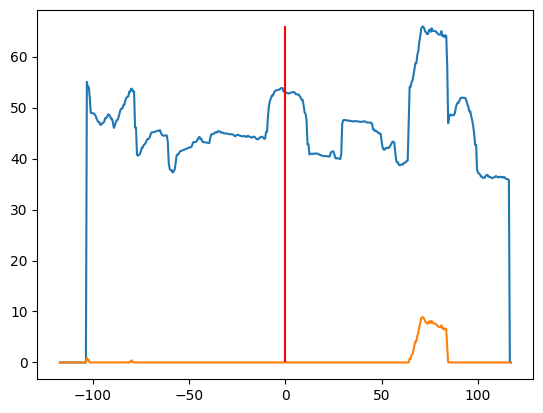

In [11]:
EW = np.max(h[:,h.shape[1]//2-10:h.shape[1]//2+10],axis=1)
N,S  = getAngles(EW, debug = True)

# Etude à 45°

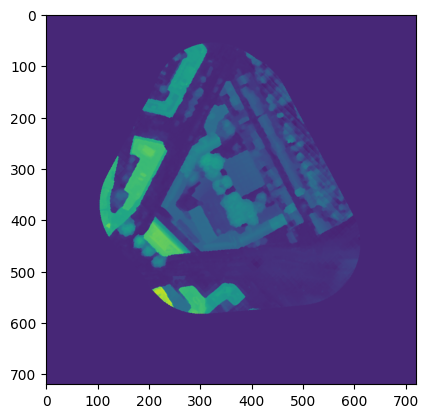

In [12]:
plt.imshow(Hbis)

### Profil des hauteurs selon un Axe NE/SW

Values 7 3


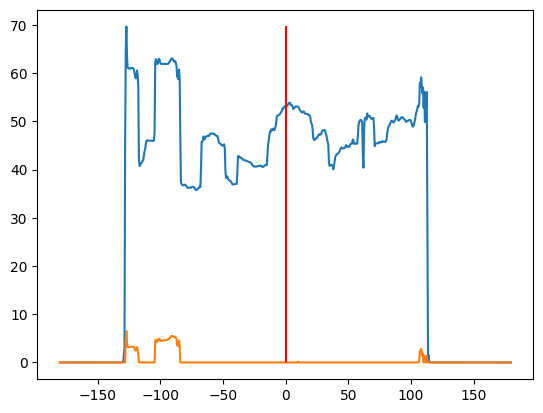

In [13]:
EW =  np.max(hbis[hbis.shape[0]//2-10:hbis.shape[0]//2+10],axis=0) 
SW,NE= getAngles(EW, debug=True)

# Plein calcul

In [14]:
print("Gain de temps par batiment si cached:",int(7.59/0.199),"x")

Gain de temps par batiment si cached: 38 x


In [29]:
# %%timeit -n 5 -r 3
# 7.59 s ± 4.39 s per loop (mean ± std. dev. of 3 runs, 5 loops each)
get_horizon_roof(ecole_cible, crs= ecole_cible.crs, cache = False) 

[1, 3, 2, 2, 10, 7, 1, 0]

In [27]:
# %%timeit -n 5 -r 3
# 199 ms ± 9.12 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)
get_horizon_roof(ecole_cible, crs= ecole_cible.crs, cache = True) 

[1, 3, 2, 2, 10, 7, 1, 0]

# Test dans une fonction

### Pour une école, globalement

In [17]:
for ix, row in ecole_cible.iterrows():
    h = get_horizon_roof(row, crs= batiments_ecole.crs, cache = True) 
    print (ix,"\tHorizons aux angles:\t", h )

5 	Horizons aux angles:	 [1, 3, 2, 2, 10, 7, 1, 0]


#### Pour ses batiments

In [18]:
for ix, row in batiments_ecole.iterrows():
    h = get_horizon_roof(row, crs= batiments_ecole.crs, cache = True) 
    print (ix,"\tHorizons aux angles:\t", h )

7 	Horizons aux angles:	 [0, 0, 2, 25, 0, 0, 0, 26]
14 	Horizons aux angles:	 [15, 40, 0, 21, 0, 31, 0, 12]
15 	Horizons aux angles:	 [0, 0, 0, 0, 0, 0, 0, 0]
16 	Horizons aux angles:	 [0, 0, 0, 0, 0, 0, 0, 0]
17 	Horizons aux angles:	 [0, 0, 0, 22, 0, 42, 5, 50]
18 	Horizons aux angles:	 [0, 0, 0, 0, 0, 0, 0, 0]
19 	Horizons aux angles:	 [0, 0, 18, 0, 0, 0, 13, 29]
21 	Horizons aux angles:	 [0, 0, 76, 0, 0, 0, 0, 0]
22 	Horizons aux angles:	 [0, 0, 0, 0, 0, 0, 0, 0]
24 	Horizons aux angles:	 [0, 0, 0, 0, 0, 0, 0, 0]
106 	Horizons aux angles:	 [3, 36, 1, 28, 0, 32, 2, 20]


In [19]:
batiments_ecole["horizons"] = batiments_ecole.apply(lambda row: get_horizon_roof(row, crs= batiments_ecole.crs, cache = True), axis=1 )
batiments_ecole[["cleabs_left__bat","horizons"]]

,cleabs_left__bat,horizons
7,BATIMENT0000000243399191,"[0, 0, 2, 25, 0, 0, 0, 26]"
14,BATIMENT0000000243399973,"[15, 40, 0, 21, 0, 31, 0, 12]"
15,BATIMENT0000000243399188,"[0, 0, 0, 0, 0, 0, 0, 0]"
16,BATIMENT0000000243399190,"[0, 0, 0, 0, 0, 0, 0, 0]"
17,BATIMENT0000000243399187,"[0, 0, 0, 22, 0, 42, 5, 50]"
18,BATIMENT0000000243399972,"[0, 0, 0, 0, 0, 0, 0, 0]"
19,BATIMENT0000000243399189,"[0, 0, 18, 0, 0, 0, 13, 29]"
21,BATIMENT0000000243399192,"[0, 0, 76, 0, 0, 0, 0, 0]"
22,BATIMENT0000000243399193,"[0, 0, 0, 0, 0, 0, 0, 0]"
24,BATIMENT0000000243400186,"[0, 0, 0, 0, 0, 0, 0, 0]"


# Tests API calls

In [20]:
import requests
import requests_cache


from potentiel_solaire.constants import DATA_FOLDER
session = requests_cache.CachedSession(DATA_FOLDER / "cache" / 'requests')

In [21]:
PVGIS_BASE_URL = "https://re.jrc.ec.europa.eu/api/v5_2/PVcalc?&"
DEFAULT_QUERY_PARAMS = {
    "outputformat": "json",
    "loss": 14,  # The system's losses in percentage. Recommend between 15 - 30 %
    "fixed": 1,  # Fixed versus solar tracking system. Fixed in case of solar rooftop.
    "mountingplace": 'building',  # Param should impacts losses. We may be double counting.
    "optimalangles": 1,  # Letting the engine optimise the ti
}

def get_potentiel_solaire_from_pvgis_api(
    latitude: float,
    longitude: float,
    peakpower: float,
    usrhorizon: list = [],
    cache: bool = False
) -> float:
    
    if peakpower <= 0:
        return 0.0

    params = {
        "lat": latitude,
        "lon": longitude,
        "peakpower": peakpower,
        **DEFAULT_QUERY_PARAMS
    }

    if len(usrhorizon):
        # On ajoute les horizons si on les a
        params["userhorizon"] = ",".join([str(x) for x in usrhorizon])

    if cache:
        # Pour des raisons de performance (rapidité) on peut cacher les retour APIs
        response = session.get(PVGIS_BASE_URL, params=params)
    else:
        response = requests.get(PVGIS_BASE_URL, params=params)

    response.raise_for_status()
    
    if response.status_code == 200:
        data = response.json()
        return data


# Comparons l'impact des horizons sur la production (avec ou sans user horizon)

In [22]:
def get_data_batiment(batiment, puissance=1000.0, usrhorizon=[], cache=False):
    # Call de l'API avec les horizons
    lat = batiment["lat"]
    lon = batiment["lon"]
    if len(batiment["horizons"]):
        usrhorizon = batiment["horizons"]
    return get_potentiel_solaire_from_pvgis_api(lat,lon,puissance,usrhorizon, cache)

In [23]:
def get_data_batiment_no_horizon(batiment, puissance=1000.0, usrhorizon=[], cache=False):
    # Call de l'API sans les horizons
    lat = batiment["lat"]
    lon = batiment["lon"]
    return get_potentiel_solaire_from_pvgis_api(lat,lon,puissance,usrhorizon, cache)

In [24]:
batiments_ecole = batiments_ecole.to_crs(4326)
# Besoin des latlon pour l'API PVGIS
batiments_ecole["lon"] = batiments_ecole.centroid.map(lambda p: p.x)
batiments_ecole["lat"] = batiments_ecole.centroid.map(lambda p: p.y)
batiments_ecole = batiments_ecole.to_crs(2154)
# On prend toutes les données du call API
batiments_ecole["data"] = batiments_ecole.apply(lambda row: get_data_batiment(row, puissance=1000.0, cache = True), axis = 1)
batiments_ecole["EM_Horizons"] = batiments_ecole.data.apply(lambda x: x["outputs"]["totals"]["fixed"]['E_m'])
batiments_ecole["data"] = batiments_ecole.apply(lambda row: get_data_batiment_no_horizon(row, puissance=1000.0, cache = True), axis = 1)
batiments_ecole["EM_No_Horizons"] = batiments_ecole.data.apply(lambda x: x["outputs"]["totals"]["fixed"]['E_m'])
# Et on calcule l'impact
batiments_ecole["impact_ombre"] = batiments_ecole.apply(lambda x: x["EM_Horizons"]  / x["EM_No_Horizons"], axis = 1)
batiments_ecole[["cleabs_left__bat","impact_ombre"]]

,cleabs_left__bat,impact_ombre
7,BATIMENT0000000243399191,0.971779
14,BATIMENT0000000243399973,0.940185
15,BATIMENT0000000243399188,1.000000
16,BATIMENT0000000243399190,1.000000
17,BATIMENT0000000243399187,0.904032
18,BATIMENT0000000243399972,1.002585
19,BATIMENT0000000243399189,0.997793
21,BATIMENT0000000243399192,0.950795
22,BATIMENT0000000243399193,1.002585
24,BATIMENT0000000243400186,1.002149


In [25]:
# E_m [kWh/mo] - Average monthly PV production  (kWh)
batiments_ecole.data.iloc[0]["outputs"]["totals"]["fixed"]['E_m']

91637.42

# Resultat

Cf ici : https://joint-research-centre.ec.europa.eu/photovoltaic-geographical-information-system-pvgis/getting-started-pvgis/api-non-interactive-service_en

**userhorizon**	--> Height of the horizon at equidistant directions around the point of interest, in degrees. Starting at north and moving clockwise. The series '0,10,20,30,40,15,25,5' would mean the horizon height is 0° due north, 10° for north-east, 20° for east, 30° for south-east, etc.

Autres resources
* https://pvgis.com/fr/manuel-utilisateur
* https://joint-research-centre.ec.europa.eu/photovoltaic-geographical-information-system-pvgis/getting-started-pvgis/pvgis-user-manual_en


In [26]:
userhorizon = str([N,NE,E,SE,S,SW,W,NW])
userhorizon

'[1, 3, 2, 2, 10, 7, 1, 0]'

# Example de PVGIS

## Atttention: leurs horizons calculé prendre le terrain, pas la surface (eg les batiments sont retirés)

![](https://cdn.pvgis.com/images/user-manual/horizon-information-v3.png)